<a href="https://colab.research.google.com/github/ahmetybilgin/DrRacketCal-sma/blob/master/Emotion_Perception_Detection_in_Text(test190719).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Emotion Dataset
In this notebook, we are working on an emotion classification dataset which contains tweets labeled into 6 categories (joy, sadness, anger, fear, love, surprise). 
[Source Kernel](https://www.kaggle.com/eray1yildiz/using-lstms-with-attention-for-emotion-recognition/data)

### Let's start exploring the dataset

In [0]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

#Loading the dataset 
dataset = pd.read_csv("../input/emotion.data")
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 416809 entries, 0 to 416808
Data columns (total 3 columns):
Unnamed: 0    416809 non-null int64
text          416809 non-null object
emotions      416809 non-null object
dtypes: int64(1), object(2)
memory usage: 9.5+ MB


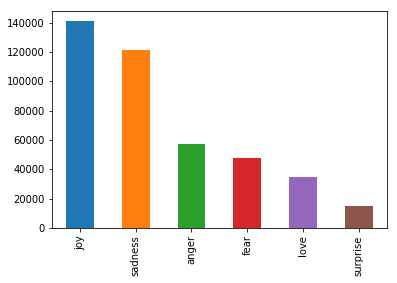

In [0]:
# Plot label histogram
dataset.emotions.value_counts().plot.bar()

Text(0.5, 1.0, 'Emotion Distribution')

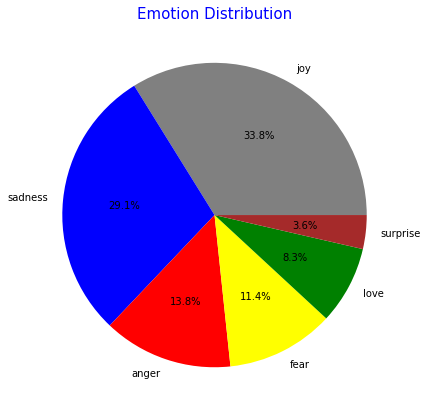

In [0]:
# pie chart
dataset.emotions.dropna(inplace = True)
labels = dataset.emotions.value_counts().index
colors = ['grey','blue','red','yellow','green','brown']
explode = [0,0,0,0,0,0]
sizes = dataset.emotions.value_counts().values
# visual
plt.figure(figsize = (7,7))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%')
plt.title('Emotion Distribution',color = 'blue',fontsize = 15)

## Preparing data for model training
### Tokenization
Since the data is already tokenized and lowercased, we just need to split the words.
/Veriler zaten belirtilmiş ve küçük harfe dönüştürülmüş olduğundan, sadece kelimeleri bölmemiz gerekir.


In [0]:
input_sentences = [text.split(" ") for text in dataset["text"].values.tolist()] #kelimelerine ayır
labels = dataset["emotions"].values.tolist()
print (input_sentences[1])
print (labels[1])

['im', 'alone', 'i', 'feel', 'awful']
sadness


### Creating Vocabulary (word index)

In [0]:
# Initialize word2id and label2id dictionaries that will be used to encode words and labels
word2id = dict()
label2id = dict()
max_words = 0 # maximum number of words in a sentence
# Construction of word2id dict
for sentence in input_sentences: # dict çevrilen textler içine gir
    for word in sentence: 
        # Add words to word2id dict if not exist. Eğer yoksa, word2id dict'a words ekleyin.
        if word not in word2id:
            word2id[word] = len(word2id)
    # If length of the sentence is greater than max_words, update max_words
    if len(sentence) > max_words:
        max_words = len(sentence)    
# Construction of label2id and id2label dicts
label2id = {l: i for i, l in enumerate(set(labels))}
id2label = {v: k for k, v in label2id.items()}
print(id2label)
print(label2id)

{0: 'love', 1: 'anger', 2: 'fear', 3: 'surprise', 4: 'joy', 5: 'sadness'}
{'love': 0, 'anger': 1, 'fear': 2, 'surprise': 3, 'joy': 4, 'sadness': 5}


### Encoding samples with corresponing integer values
Karşılık gelen tamsayı değerleri ile örnekleri kodlama.

In [0]:
import keras
from keras.models import Sequential
from keras.layers import Dense
# Encode input words and labels
X = [[word2id[word] for word in sentence] for sentence in input_sentences]
Y = [label2id[label] for label in labels]
# Apply Padding to X
from keras.preprocessing.sequence import pad_sequences #dolgu yapmak için
#pad_sequences is used to ensure that all sequences in a list have the same length. 
#By default this is done by padding 0 in the beginning of 
#each sequence until each sequence has the same length as the longest sequence.

X = pad_sequences(X, max_words) # x'e dolgu yap maxword sayısınca
# Convert Y to numpy array
Y = keras.utils.to_categorical(Y, num_classes=len(label2id), dtype='float32')
# Print shapes
print("Shape of X: {}".format(X.shape))
print("Shape of Y: {}".format(Y.shape))

Using TensorFlow backend.


Shape of X: (416809, 178)
Shape of Y: (416809, 6)


## Build LSTM model with attention 

**activation='softmax'** Optimizer that implements the Adam algorithm. Ağın eğitilmesi için kullanılacak optimizasyon fonkisyonu eğitimin durumunu ve ölçümünü veren parametreler verilir. 

**Loss Fonksiyonları**
Ağın eğitimi esnasında Ağın ileri doğru çalışıp ürettiği çıkış değerleri ile gerçek çıkış değerlerini karşılaştırıp. Ağın eğitimesi için geri besleme degeri üreten fonksiyonlardır.

**categorical_crossentropy:** Çok sınıflı logloss olarak da bilinir. Not: Bu amacı kullanmak, etiketlerinizin ikili biçimli diziler olmasını gerektirir (nb_samples, nb_classes).

**Metric :**
Compile fonksiyonu için gireceğimiz son parametre metric parametresidir. Fakat Hali hazırda kodlanmış alternatif çeşitler yoktur yegane seçeneğiniz ‘accuracy’ dir. Size 0-1 arasında bir doğruluk değeri gösterir.

**Eğitim Fonksiyonu ( Fit ) :**
Yapısı tanımlanmış ve compile işlemi yapılmış ağların eğitimi için model sınıfının fit fonksiyonu çağrılır. 

*Önce Fonksiyonun tanımlamasına bakalım*
--


fit( x, y, batch_size=32, nb_epoch=10, verbose=1, callbacks=[], validation_split=0.0, validation_data=None, shuffle=True, class_weight=None, sample_weight=None)
##Ağı sabit bir iterasyon sayısınca eğitir.

Parametreler

x: Giriş verisi Numpy dizisi yada Numpy dizilerini tutan liste (Eğer Ağın çoklu girişi varsa).
y: Giriş verisine ait Etiketler Numpy dizisi
batch_size: Bir ileri çalışma ve geri yayılma esnasında kullanılacak örnek sayısı Tamsayı
nb_epoch: iterasyon sayısı Bütün veri setinin kaç kez tekrar eğitimde kullanılacağı
verbose: eğitim esnasında verilecek ilerleme bilgisini ayarlayan parametre
0 : stdout a bir çıkış yok
1 : ilerleme çubuğuyla göster.
2 : her iterasyon için tek ilerleme çubuğu gösterir
callbacks: Eğitim esnasında çalışıtırılan fonksiyonlar bakınız callbacks
validation_split: (0. < x < 1). bir oran da verinin bir kısmını eğitimde kullanmayıp doğrulama -validation – için kullanılır. Meseala 0.2 demek Eğitim verisinin %20 sinin doğrulama işlemi için kullanılacağı anlamına gelir.
validation_data: Doğrulama için Eğitim verisinden ayrı olarak veride verebiliriz bu şekilde tuple tipinde (X, y) Eğitim verisindeki Gibi X giriş Y etiketleri tuan Numpy dizileridir.
shuffle: Her iterasyonda eğitim verisinin sırasının karıştırılmasını sağlar True ise
class_weight: Eğitim esnasında loss hesaplanırken her sınıf için ayrı ağırlık parametresi dict tipinde
sample_weight: Eğitim veri setinde loss hesabında her örnek için ayrı bir katsayı kullanımına imkan verir

**Fonksiyon Dönüşdeğeri**
History Nesnesi döner Eğitim esnasındaki hemen herşeyi tutar. ( eğitim ve doğrulama için loss ve metrik değerler vs...)

YSA ksımında ise girdi sayısının ve katman sayısının büyüklüğü sebebiyle klasik metodlarla eğitimi  pek kolay değildir. Bu yüzden gerek öğrenememe -under fitting - gerekse ezberleme - over fitting - problemleri 2 için modern çözümler ve kullanılmaktadır. 
Mesela ; Dropout diye tabir edilen bir yöntem var.  Ağ içindeki bazı bağlantıların kaldırılmasıyla  eğitim performansı artırıyor.
Dropout Katmanı  ; Ağ içindeki bazı bağlantıların kaldırılmasıyla  eğitim performansı artacağı varsayılıyor.  Dropout katmanına  0 dan büyük 1 den küçük bir oran veriyorsunuz. Eğitim esnasında bu oran miktarındaki bağlantıyı rastgele kapatıyor.

[Kaynak için](http://derindelimavi.blogspot.com/2017/01/keras-giris-1.html)

In [0]:
embedding_dim = 100 # The dimension of word embeddings
# Define input tensor
sequence_input = keras.Input(shape=(max_words,), dtype='int32')
# Word embedding layer
embedded_inputs =keras.layers.Embedding(len(word2id) + 1,
                                        embedding_dim,
                                        input_length=max_words)(sequence_input)

# Apply dropout to prevent overfitting / Aşırı uyumu önlemek için bırakma uygula
embedded_inputs = keras.layers.Dropout(0.2)(embedded_inputs)
# Apply Bidirectional LSTM over embedded inputs / Gömülü girişler üzerine Çift Yönlü LSTM uygulama
lstm_outs = keras.layers.wrappers.Bidirectional(
    keras.layers.LSTM(embedding_dim, return_sequences=True)
)(embedded_inputs)

# Apply dropout to LSTM outputs to prevent overfitting
lstm_outs = keras.layers.Dropout(0.2)(lstm_outs)
# Attention Mechanism - Generate attention vectors
input_dim = int(lstm_outs.shape[2])
permuted_inputs = keras.layers.Permute((2, 1))(lstm_outs)
attention_vector = keras.layers.TimeDistributed(keras.layers.Dense(1))(lstm_outs)
attention_vector = keras.layers.Reshape((max_words,))(attention_vector)
attention_vector = keras.layers.Activation('softmax', name='attention_vec')(attention_vector)
"""
Sınıfların olasılıklarını hesaplamak için "Softmax" fonksiyonu/ 
 Çoklu sınıflandırma problemleri için kullanılan bu fonksiyon, verilen her 
 bir girdinin bir sınıfa ait olma olasılığını gösteren [0,1] arası çıktılar üretmektedir.
"""
attention_output = keras.layers.Dot(axes=1)([lstm_outs, attention_vector])                   
                                                                                              
# Last layer: fully connected with softmax activation
fc = keras.layers.Dense(embedding_dim, activation='relu')(attention_output)
output = keras.layers.Dense(len(label2id), activation='softmax')(fc)

# Finally building model
model = keras.Model(inputs=[sequence_input], outputs=output)
model.compile(loss="categorical_crossentropy", metrics=["acc"], optimizer='adam') 
# Print model summary
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 178)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 178, 100)     7530300     input_1[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 178, 100)     0           embedding_1[0][0]                
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 178, 200)     160800      dropout_1[0][0]                  
__________________________________________________________________________________________________
dropout_2 

**LSTM** ler  genel anlamda sequence zaman sıralı şekilde gelen veriler üzerinden çalışırlar.

      keras.layers.recurrent.LSTM(output_dim,
                          batch_input_shape=(nb_samples, timesteps, input_dim), 
                          return_sequences=False,....)  #eğer LSTM ilk katmansa batch_input_shape  verilmesi gerekiyor ve dökümanda geçen şekli
  
nb_samples : veri sayımız, None diyede  verebiliyoruz. 

timesteps :  LSTM e vereceğimiz veriler zaman bazında değişen aynı türdeki veriler kaç birim zamanlık veri verilecek burda onu belirtmemiz gerekiyor.

input_dim :  giriş verimizin boyutu.

return_sequences : Kendinden sonraki katman Yine Bir LSTM olacaksa True yapılacak

output_dim :  Katman çıkış boyutu ve LSTM birim sayısı.  Ağın çıkışı , eğer kendinden sonraki katman Yine Bir LSTM olacaksa  (nb_samples, timesteps, output_dim) olmayacaksa  (nb_samples, , output_dim) olur.

## Training the model

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.025)
print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)
history = model.fit(X, Y, epochs=5, batch_size=128, validation_data = (X_test, y_test), shuffle=True, verbose=1)

(406388, 178) (406388, 6)
(10421, 178) (10421, 6)
Train on 416809 samples, validate on 10421 samples
Epoch 1/5
416809/416809 [==============================] - 2342s 6ms/step - loss: 0.2427 - acc: 0.8868 - val_loss: 0.0893 - val_acc: 0.9408
Epoch 2/5
416809/416809 [==============================] - 2220s 5ms/step - loss: 0.0914 - acc: 0.9411 - val_loss: 0.0854 - val_acc: 0.9442
Epoch 3/5
416809/416809 [==============================] - 2223s 5ms/step - loss: 0.0857 - acc: 0.9427 - val_loss: 0.0804 - val_acc: 0.9446
Epoch 4/5
416809/416809 [==============================] - 2221s 5ms/step - loss: 0.0834 - acc: 0.9436 - val_loss: 0.0795 - val_acc: 0.9434
Epoch 5/5
416809/416809 [==============================] - 2216s 5ms/step - loss: 0.0814 - acc: 0.9435 - val_loss: 0.0779 - val_acc: 0.9486


In [0]:
model.save('TextEmotionLSTM.h5')
with open('
          .json', 'w') as f:
    f.write(model.to_json())
print('Model saved.')

Model saved.


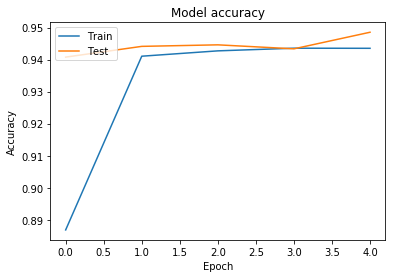

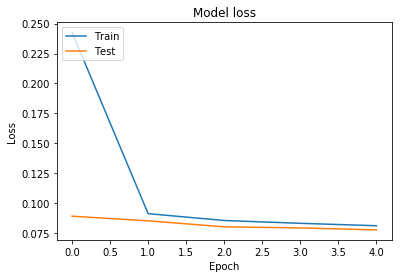

In [0]:
# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [0]:
from sklearn.metrics import confusion_matrix
model.reset_states()
y_pred = model.predict(X_test, batch_size=64)
yPred = [np.argmax(line) for line in y_pred]
yPred = np.array(yPred)[:, None]
yTest = [np.argmax(line) for line in y_test]
yTest = np.array(yTest)[:, None]
cm = confusion_matrix(yTest, yPred)
print('TEST CONFUSION MATRIX')
print(cm)

TEST CONFUSION MATRIX
[[ 648    0    0    0  157    0]
 [   0 1434   53    0    1    2]
 [   0    0 1061   81    0    4]
 [   0    0    0  328   36    0]
 [  82    0    3    0 3400    1]
 [   0   64   50    2    0 3014]]


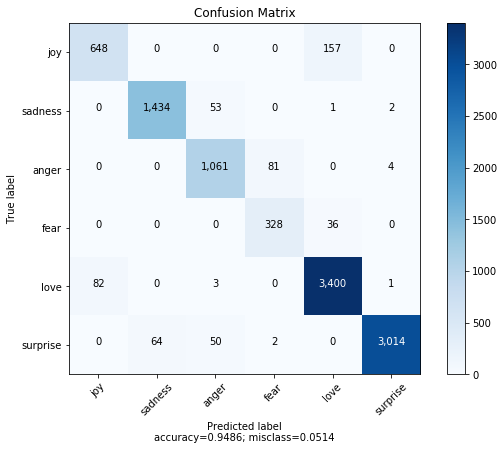

In [0]:
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()
    
plot_confusion_matrix(cm           = np.array(cm), 
                      normalize    = False,
                      target_names = ["joy", "sadness", "anger", "fear", "love", "surprise"],
                      title        = "Confusion Matrix")

In [0]:
# Re-create the model to get attention vectors as well as label prediction
model_with_attentions = keras.Model(inputs=model.input,
                                    outputs=[model.output, 
                                             model.get_layer('attention_vec').output])

enter text ?I know it has sentimental value to you because your dad bought it new.
i know it has sentimental value to you because your dad bought it new


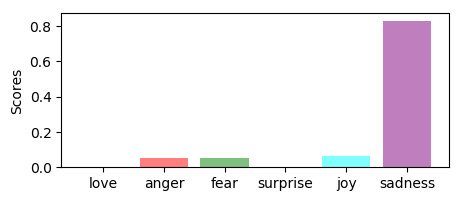

In [0]:
import math
import re

# enter text
text = input("enter text ?")

sample_text =  (re.sub('[^A-Za-z0-9]+', ' ', text)).lower().strip()
print(sample_text)

# Encode samples
tokenized_sample = sample_text.split(" ")
encoded_samples = [[word2id[word] for word in tokenized_sample]]

# Padding
encoded_samples = keras.preprocessing.sequence.pad_sequences(encoded_samples, maxlen=max_words)

# Make predictions
label_probs, attentions = model_with_attentions.predict(encoded_samples)
label_probs = {id2label[_id]: prob for (label, _id), prob in zip(label2id.items(),label_probs[0])}

# Get word attentions using attenion vector
token_attention_dic = {}
max_score = 0.0
min_score = 0.0
for token, attention_score in zip(tokenized_sample, attentions[0][-len(tokenized_sample):]):
    token_attention_dic[token] = math.sqrt(attention_score)

# VISUALIZATION
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt
from IPython.core.display import display, HTML

def rgb_to_hex(rgb):
    return '#%02x%02x%02x' % rgb
    
def attention2color(attention_score):
    r = 255 - int(attention_score * 255)
    color = rgb_to_hex((255, r, r))
    return str(color)
    
# Build HTML String to viualize attentions
html_text = "<hr><p style='font-size: large'><b>Text:  </b>"
for token, attention in token_attention_dic.items():
    html_text += "<span style='background-color:{};'>{} <span> ".format(attention2color(attention),
                                                                        token)
html_text += "</p>"
# Display text enriched with attention scores 
display(HTML(html_text))

# PLOT EMOTION SCORES
emotions = [label for label, _ in label_probs.items()]
scores = [score for _, score in label_probs.items()]
plt.figure(figsize=(5,2))
plt.bar(np.arange(len(emotions)), scores, align='center', alpha=0.5, color=['black', 'red', 'green', 'blue', 'cyan', "purple"])
plt.xticks(np.arange(len(emotions)), emotions)
plt.ylabel('Scores')
plt.show()

i feel that i have been wronged


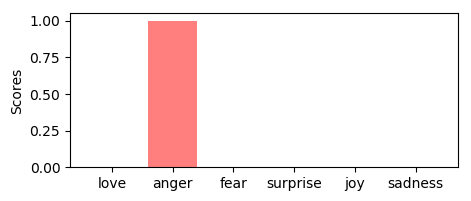

In [0]:
import random
import math

# Select random samples to illustrate
sample_text = random.choice(dataset["text"].values.tolist())
print(sample_text)

# Encode samples
tokenized_sample = sample_text.split(" ")
encoded_samples = [[word2id[word] for word in tokenized_sample]]

# Padding
encoded_samples = keras.preprocessing.sequence.pad_sequences(encoded_samples, maxlen=max_words)

# Make predictions
label_probs, attentions = model_with_attentions.predict(encoded_samples)
label_probs = {id2label[_id]: prob for (label, _id), prob in zip(label2id.items(),label_probs[0])}

# Get word attentions using attenion vector
token_attention_dic = {}
max_score = 0.0
min_score = 0.0
for token, attention_score in zip(tokenized_sample, attentions[0][-len(tokenized_sample):]):
    token_attention_dic[token] = math.sqrt(attention_score)


# VISUALIZATION
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt
from IPython.core.display import display, HTML

def rgb_to_hex(rgb):
    return '#%02x%02x%02x' % rgb
    
def attention2color(attention_score):
    r = 255 - int(attention_score * 255)
    color = rgb_to_hex((255, r, r))
    return str(color)
    
# Build HTML String to viualize attentions
html_text = "<hr><p style='font-size: large'><b>Text:  </b>"
for token, attention in token_attention_dic.items():
    html_text += "<span style='background-color:{};'>{} <span> ".format(attention2color(attention),
                                                                        token)
html_text += "</p>"
# Display text enriched with attention scores 
display(HTML(html_text))

# PLOT EMOTION SCORES
emotions = [label for label, _ in label_probs.items()]
scores = [score for _, score in label_probs.items()]
plt.figure(figsize=(5,2))
plt.bar(np.arange(len(emotions)), scores, align='center', alpha=0.5, color=['black', 'red', 'green', 'blue', 'cyan', "purple"])
plt.xticks(np.arange(len(emotions)), emotions)
plt.ylabel('Scores')
plt.show()